In [124]:
from keras.layers import Conv2D, UpSampling2D, Input, MaxPooling2D, BatchNormalization, LeakyReLU
from keras.layers.merging import concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.callbacks import EarlyStopping
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imsave
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import io
from PIL import Image, ImageFilter
import cv2
import os
import requests
import pandas as pd
from urllib.request import urlopen

In [125]:
from keras.layers.regularization.spatial_dropout3d import Dropout
from keras.layers.activation.prelu import PReLU
from keras.layers.reshaping.cropping2d import Cropping2D

In [291]:
path = "photos/train/"
testPath = "photos/test/"

In [351]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory(path, target_size=(256,256), batch_size=25, class_mode=None)

Found 1500 images belonging to 1 classes.


In [352]:
test_gen = ImageDataGenerator(rescale=1./255)
test = test_gen.flow_from_directory(testPath, target_size=(256, 256), batch_size=25, class_mode=None)

Found 1500 images belonging to 1 classes.


# Previous Work

In [78]:
def rgb_2_gray(image):
    return np.dot(image[..., :3], [0.299, 0.587, 0.114])

In [79]:
def prepImage(path):
    color_img = []
    bw_img = []
    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path+imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            img = cv2.resize(img, (256,256))
            img = img.astype('float32') / 255.0

            color_img.append(img_to_array(img))

            bw_img.append(rgb_2_gray(img_to_array(img)))
        
        except:
            pass

        return np.array(bw_img), np.array(color_img)

In [80]:
def ExtractInput(path):
    X_img=[]
    y_img=[]
    i=0

    for imageDir in os.listdir(path):
        try:
            img = cv2.imread(path + imageDir)
#            img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_LINEAR) # resize image to network input size
#            plt.imshow(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          #  plt.imshow(img)
         #   img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
           # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

     #       kernel = np.ones((4,4),np.float32)/16
    #        img = cv2.filter2D(img,-1,kernel)
           # img = cv2.GaussianBlur(img,(5,5),0)
    
            img = img.astype(np.uint8)
            img_lab = rgb2lab(img)
#            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            
            #Convert the rgb values of the input image to the range of 0 to 1
            #1.0/255 indicates that we are using a 24-bit RGB color space.
            #It means that we are using numbers between 0–255 for each color channel
            img_lab = 1.0/225*img_lab
            # resize the lightness channel to network input size 
            #img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab[:,:,0] # pull out L channel
            #img_l -= 50 # subtract 50 for mean-centering
            img_ab = img_lab[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [81]:
def ExtractTestInput(img):
    print("changing colors")
    img = img[:,:,:3]
    print(img.shape)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print(img.shape)

    img_ = rgb2lab(img)
    
    img_=img_.astype(np.float32)
    print('image converted')
    img_lab_rs = cv2.resize(img_, (256, 256)) # resize image to network input size
    print("image resized")
    img_l = img_lab_rs[:,:,0] # pull out L channel
    #img_l -= 50
    img_l_reshaped = img_l.reshape(1,256,256,1)
    print("luminance reshaped")
 #   else:
  #    return "invalid image"
    
    return img_l_reshaped

In [82]:
X_,y_ = ExtractInput(path+"train_data/") # Data-preprocessing

In [12]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [13]:
X_[0].shape

(256, 256)

In [14]:
y_[0].shape

(256, 256, 2)

In [15]:
X_test[0].shape

(256, 256)

In [137]:
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
    model_ = PReLU()(model_)
    #model_ = Conv2D(64,(3,3), activation='relu',strides=1)(model_)
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)
    
#    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
 #   model_ = PReLU()(model_)
  #  model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)
    
#    model_ = UpSampling2D((2, 2))(model_)
#    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
#    model_ = PReLU()(model_)
 #   model_ = BatchNormalization()(model_)
    
 #   concat_ = concatenate([model_, in_]) 
    
#    model_ = Conv2D(128,(3,3), padding='same',strides=1)(concat_)
 #   model_ = PReLU()(model_)
  #  model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)

    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(model_)
    model_ = PReLU()(model_)
    model_ = BatchNormalization()(model_)

    concat_ = concatenate([model_, in_])
    
    model_ = Conv2D(2,(3,3), activation='sigmoid',padding='same',strides=1)(model_)

    return model_

In [17]:
Input_Sample = Input(shape=(256, 256,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_) #Model groups layers into an object with training and inference features.

In [ ]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error',
                            metrics=["accuracy"])
Model_Colourization.summary()

In [ ]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)

Model_Colourization.fit(GenerateInputs(X_,y_),epochs=12,verbose=1, steps_per_epoch=8,shuffle=True, validation_data=(X_test, y_test))

In [ ]:
ImagePath="photos/test/test_data/8R0l7vkXTXk.jpg"
img = cv2.imread(ImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = Model_Colourization.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(ImagePath)
#img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
#img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img = cv2.resize(img, (256, 256))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
#img = cv2.GaussianBlur(img,(5,5),0)
#kernel = np.ones((3,3),np.float32)/16
#img = cv2.filter2D(img,-1,kernel)
#plt.imshow(img)

img_bw = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_bw, cmap="gray")
img_ = rgb2lab(img)
img_bw = img_[:,:,0]
#img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
print(img_)
img_[:,:,1:] = Prediction
print(img_)
#img_[:,:,1] = Prediction[0]
#img_[:,:,2] = Prediction[1]
img_ = lab2rgb(img_)
#img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
#img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2BGR)
plt.subplot(5,5,1+1)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img)

# Convolutional Neural Network

## Model Testing Ideas:

* Using different types of activation functions. 
    - PreLU
    - <mark>Leaky ReLU</mark>
    - ReLU
* Changing the validation
    - <mark>with</mark> or without validation set
    - validation steps
* Changing the complexity of the model. 
    - conv2D based network with incrementing filter sizes until 256 and decrementing back to 16
    - conv2D based network with incrementing filter sizes until 128 and decrementing back to 16
    - conv2D based network with incrementing filter sizes until 64 and decrementing back to 16
    - only increments
* Using different preprocessing techniques
    - adding blur to images before entering the network
    - trying differently sized images
    - maybe some kind of other smoothing or denoising effect
* Trying different learning rates
* Trying different optimizers

In [353]:
HEIGHT=256
WIDTH=256
ImagePath="photos/train/train_data/"

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for imageDir in os.listdir(ImagePath):
        try:
            img = cv2.imread(ImagePath + imageDir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    #        img = cv2.GaussianBlur(img,(10,10),0)
    
            img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            # resize the lightness channel to network input size 
            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT)) # resize image to network input size
            img_l = img_lab_rs[:,:,0] # pull out L channel
            img_ab = img_lab_rs[:,:,1:]#Extracting the ab channel
            img_ab = img_ab/128
            #The true color values range between -128 and 128. This is the default interval 
            #in the Lab color space. By dividing them by 128, they too fall within the -1 to 1 interval.
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    
    return X_img,y_img

In [354]:
X_,y_ = ExtractInput(ImagePath) # Data-preprocessing

In [355]:
X_test, y_test = ExtractInput(testPath+"test_data/")

In [356]:
X_[0].shape

(256, 256)

In [357]:
X_test[0].shape

(256, 256)

In [358]:
from keras.layers import ReLU

In [359]:
def InstantiateModel(in_):
    model_ = Conv2D(16,(3,3),padding='same',strides=1)(in_)
#    model_ = LeakyReLU()(model_)
    model_ = ReLU()(model_)

    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
#    model_ = LeakyReLU()(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(64,(3,3),padding='same',strides=1)(model_)
#    model_ = LeakyReLU()(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    model_ = MaxPooling2D(pool_size=(2,2),padding='same')(model_)
    
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
#    model_ = LeakyReLU()(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(256,(3,3),padding='same',strides=1)(model_)
#    model_ = LeakyReLU()(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(128,(3,3),padding='same',strides=1)(model_)
#    model_ = LeakyReLU()(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = UpSampling2D((2, 2))(model_)
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(model_)
#    model_ = LeakyReLU()(model_)
    model_ = ReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    concat_ = concatenate([model_, in_]) 
    
    model_ = Conv2D(64,(3,3), padding='same',strides=1)(concat_)
#    model_ = LeakyReLU()(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(32,(3,3),padding='same',strides=1)(model_)
#    model_ = LeakyReLU()(model_)
    model_ = ReLU()(model_)
    #model_ = BatchNormalization()(model_)
    
    model_ = Conv2D(2,(3,3), activation='tanh',padding='same',strides=1)(model_)

    return model_

In [360]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [361]:
LEARNING_RATE = 0.0005
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error', metrics=["acc"])
Model_Colourization.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_150 (Conv2D)            (None, 256, 256, 16  160         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 re_lu_9 (ReLU)                 (None, 256, 256, 16  0           ['conv2d_150[0][0]']             
                                )                                                          

In [362]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=2)
history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=30)

C:\Users\jrsco\AppData\Local\Temp\ipykernel_28080\4148729522.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=30)


Epoch 1/12
5/5 [==============================] - 23s 4s/step - loss: 0.1293 - acc: 0.5384 - val_loss: 0.6166 - val_acc: 0.9945
Epoch 2/12
5/5 [==============================] - 23s 5s/step - loss: 0.0734 - acc: 0.6018 - val_loss: 0.7933 - val_acc: 0.9957
Epoch 3/12
5/5 [==============================] - 23s 5s/step - loss: 0.0483 - acc: 0.5870 - val_loss: 0.5219 - val_acc: 0.9960
Epoch 4/12


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_15/conv2d_156/Conv2D/Conv2DBackpropFilter' defined at (most recent call last):
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\jrsco\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\jrsco\AppData\Local\Temp\ipykernel_28080\4148729522.py", line 7, in <module>
      history = Model_Colourization.fit_generator(GenerateInputs(X_,y_),epochs=12,verbose=1,steps_per_epoch=5,shuffle=True,validation_data=GenerateInputs(X_test, y_test), validation_steps=30)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 2636, in fit_generator
      return self.fit(
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\optimizer_v2.py", line 585, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\optimizer_v2.py", line 643, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\jrsco\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\legacy\optimizer_v2.py", line 519, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_15/conv2d_156/Conv2D/Conv2DBackpropFilter'
OOM when allocating tensor with shape[1,65536,1152] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node gradient_tape/model_15/conv2d_156/Conv2D/Conv2DBackpropFilter}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_79039]

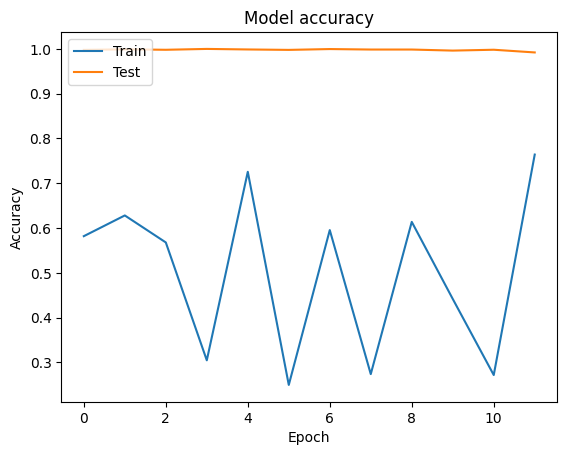

In [363]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

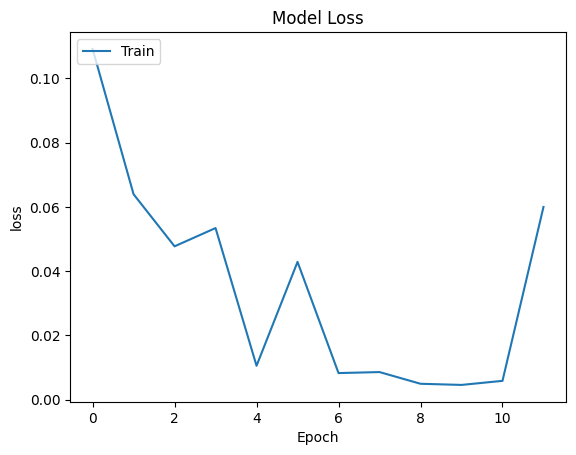

In [349]:
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [343]:
def ExtractTestInput(img):
#    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_ = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2Lab)
#    img = cv2.GaussianBlur(img,(3,3),0)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped

In [346]:
TestImagePath="photos/test/test_data/6Xz7oFdVXsg.jpg"
#TestImagePath="photos/test/test_data/5thcT9XPl9A.jpg"

img = cv2.imread(TestImagePath)
print(img.shape)
print("Loaded image")
image_for_test = ExtractTestInput(img)
print("Extracted output")
#print(image_for_test)
Prediction = Model_Colourization.predict(image_for_test)
print("Prediction made")
Prediction = Prediction*128
Prediction=Prediction.reshape(256,256,2)
print("reshaped")

(256, 256, 3)
Loaded image
Extracted output
1/1 [==============================] - 0s 306ms/step
Prediction made
reshaped


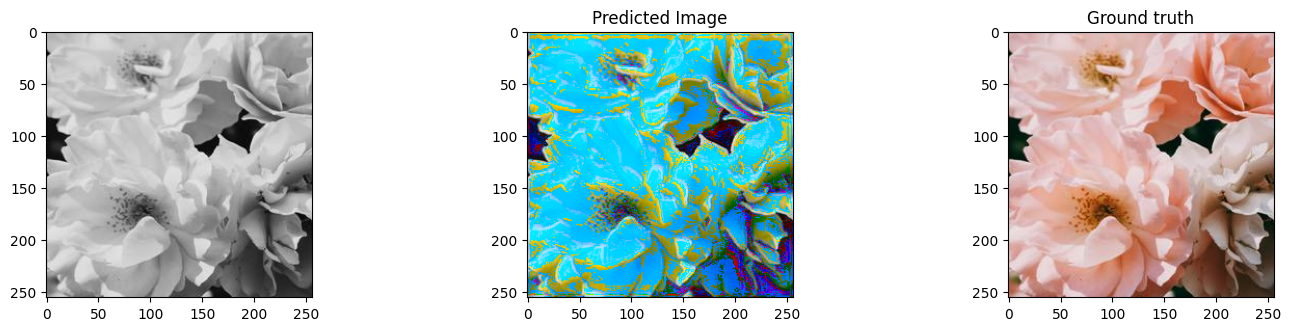

In [347]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img = cv2.imread(TestImagePath)
img_1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
#img = cv2.GaussianBlur(img,(5,5),0)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)